### Imports

In [44]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder 
from torchvision.models import ResNet50_Weights
import os
import json
import matplotlib.pyplot as plt
from collections import Counter

### EarlyStopping

In [45]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ..."
            )
        torch.save(model.state_dict(), path)
        self.val_loss_min = val_loss

### Model Preparation

In [46]:
# Load the pretrained ResNet50 model
resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Freeze all the parameters in the model
for param in resnet50.parameters():
    param.requires_grad = False

# Modify the final layer to match the number of classes
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 2)

### Transformation and Data Preparation

In [47]:
# Define data transformations
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

### Class balancing

In [48]:
# Load the full training and validation datasets
train_dataset_full = ImageFolder(root="../data/processed/train", transform=transform)
val_dataset_full = ImageFolder(root="../data/processed/val", transform=transform)


# Function to count the number of images in each class
def count_images_per_class(dataset):
    class_counts = Counter()
    for _, label in dataset.samples:
        class_counts[label] += 1
    return class_counts


# Count the number of images in each class for the full datasets
train_class_counts = count_images_per_class(train_dataset_full)
val_class_counts = count_images_per_class(val_dataset_full)

# Print the class distributions for the full datasets
print(f"Train class counts: {train_class_counts}")
print(f"Validation class counts: {val_class_counts}")


# Function to balance the dataset by limiting the number of images in each class
def balance_dataset(dataset, limit=0.1):
    # Get indices for each class
    class_indices = {
        cls: np.where(np.array(dataset.targets) == cls)[0]
        for cls in range(len(dataset.classes))
    }
    # Determine the number of images to keep per class
    min_class_count = int(
        min(len(indices) for indices in class_indices.values()) * limit
    )

    balanced_indices = []
    # Randomly select indices to balance the dataset
    for indices in class_indices.values():
        balanced_indices.extend(
            np.random.choice(indices, min_class_count, replace=False)
        )

    # Return a subset of the dataset with balanced classes
    return Subset(dataset, balanced_indices)


# Balance the training and validation datasets
train_dataset = balance_dataset(train_dataset_full, limit=0.5)
val_dataset = balance_dataset(val_dataset_full, limit=0.5)

# Create DataLoaders for the balanced datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Function to count the number of images in each class for a subset
def count_images_per_class_subset(subset):
    class_counts = Counter()
    for idx in subset.indices:
        _, label = subset.dataset.samples[idx]
        class_counts[label] += 1
    return class_counts


# Count the number of images in each class for the balanced subsets
limited_train_class_counts = count_images_per_class_subset(train_dataset)
limited_val_class_counts = count_images_per_class_subset(val_dataset)

# Print the class distributions for the balanced subsets
print(f"Limited Train class counts: {limited_train_class_counts}")
print(f"Limited Validation class counts: {limited_val_class_counts}")

Train class counts: Counter({0: 62920, 1: 44509})
Validation class counts: Counter({0: 13482, 1: 9537})
Limited Train class counts: Counter({0: 22254, 1: 22254})
Limited Validation class counts: Counter({0: 4768, 1: 4768})


### Preparation of the device, loss criterion and optimizer

In [49]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Using the GPU!")

# Move the model to the selected device
resnet50 = resnet50.to(device)
# Define the loss criterion
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=0.001)

Using the GPU!


In [50]:
# Define directories for saving checkpoints and final models
checkpoint_dir = "checkpoints/ResNet/"
saved_model_dir = "saved_models/ResNet/"

# Create directories if they don't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(saved_model_dir):
    os.makedirs(saved_model_dir)

# Define paths for the checkpoint and final model
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
saved_model_path = os.path.join(saved_model_dir, "model.pth")

### Training function

In [60]:
def train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    num_epochs=25,
    patience=5,
    checkpoint_path="checkpoint.pth",
):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    print(
        "Starting training..."
    ) 

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        print(
            f"Epoch {epoch+1}/{num_epochs}"
        )  

        for inputs, labels in dataloaders["train"]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders["train"].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders["train"].dataset)

        print( 
            f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}"
        )
        history["train_loss"].append(epoch_loss)

        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in dataloaders["val"]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(dataloaders["val"].dataset)
        val_epoch_acc = val_running_corrects.double() / len(dataloaders["val"].dataset)

        print(
            f"Validation Loss: {val_epoch_loss:.4f}, Validation Acc: {val_epoch_acc:.4f}"
        )
        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(
            val_epoch_acc.item()
        )  

        # Early stopping and checkpoint saving
        early_stopping(val_epoch_loss, model, checkpoint_path)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model, history

dataloaders = {"train": train_loader, "val": val_loader}

### Model training

In [61]:
model, history = train_model(
    resnet50,
    dataloaders,
    criterion,
    optimizer,
    num_epochs=10,
    patience=5,
    checkpoint_path=checkpoint_path,
)


# Saving the final model
torch.save(model.state_dict(), saved_model_path)

Starting training...
Epoch 1/10
Epoch 1/10, Loss: 0.0485, Acc: 0.9843
Validation Loss: 0.0469, Validation Acc: 0.9879
Validation loss decreased (inf --> 0.046903). Saving model ...
Epoch 2/10
Epoch 2/10, Loss: 0.0471, Acc: 0.9851
Validation Loss: 0.0352, Validation Acc: 0.9904
Validation loss decreased (0.046903 --> 0.035206). Saving model ...
Epoch 3/10
Epoch 3/10, Loss: 0.0474, Acc: 0.9845
Validation Loss: 0.0307, Validation Acc: 0.9920
Validation loss decreased (0.035206 --> 0.030690). Saving model ...
Epoch 4/10
Epoch 4/10, Loss: 0.0426, Acc: 0.9861
Validation Loss: 0.0327, Validation Acc: 0.9908
EarlyStopping counter: 1 out of 5
Epoch 5/10
Epoch 5/10, Loss: 0.0383, Acc: 0.9871
Validation Loss: 0.0454, Validation Acc: 0.9855
EarlyStopping counter: 2 out of 5
Epoch 6/10
Epoch 6/10, Loss: 0.0375, Acc: 0.9873
Validation Loss: 0.0297, Validation Acc: 0.9931
Validation loss decreased (0.030690 --> 0.029745). Saving model ...
Epoch 7/10
Epoch 7/10, Loss: 0.0393, Acc: 0.9876
Validation Lo

### Save and load training history

In [62]:
# Functions to save and load training history
def load_history(history_path):
    with open(history_path, "r") as f:
        history = json.load(f)
    return history


def save_history(history, history_path):
    with open(history_path, "w") as f:
        json.dump(history, f)


# Define path for saving history
history_path = os.path.join(saved_model_dir, "training_history.json")

# Save history
save_history(history, history_path)

# Load history
history = load_history(history_path)

### Plot training history

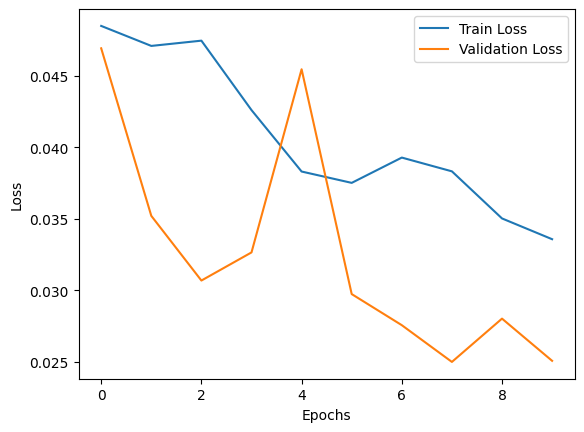

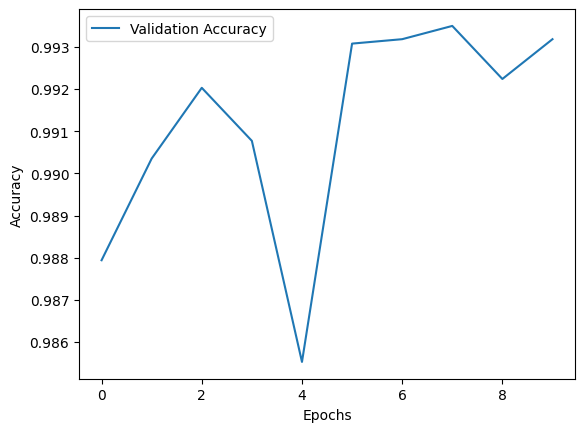

In [63]:
# Plot training and validation loss
plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure()
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Test dataset preparation

In [64]:
# Load the test dataset
test_dataset_full = ImageFolder(root="../data/processed/test", transform=transform)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset_full, batch_size=32, shuffle=False)

# Count the number of images in each class for the test dataset
test_class_counts = count_images_per_class(test_dataset_full)

# Print the class distributions for the test dataset
print(f"Test class counts: {test_class_counts}")

Test class counts: Counter({0: 13483, 1: 9539})


### Model evaluation on test dataset

In [65]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    test_running_loss = 0.0
    test_running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            test_running_loss += loss.item() * inputs.size(0)
            test_running_corrects += torch.sum(preds == labels.data)

    test_loss = test_running_loss / len(dataloader.dataset)
    test_acc = test_running_corrects.double() / len(dataloader.dataset)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    return test_loss, test_acc.item()


# Evaluate the model on the test dataset
test_loss, test_acc = evaluate_model(resnet50, test_loader, criterion)

Test Loss: 0.0287, Test Acc: 0.9921
